<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparations" data-toc-modified-id="Preparations-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparations</a></span></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset</a></span><ul class="toc-item"><li><span><a href="#Models" data-toc-modified-id="Models-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Models</a></span></li><li><span><a href="#Loading-Pretrained" data-toc-modified-id="Loading-Pretrained-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Loading Pretrained</a></span></li></ul></li><li><span><a href="#Qualitative" data-toc-modified-id="Qualitative-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Qualitative</a></span><ul class="toc-item"><li><span><a href="#Comparing-GridedCCP-and-GridedCCPXL" data-toc-modified-id="Comparing-GridedCCP-and-GridedCCPXL-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Comparing GridedCCP and GridedCCPXL</a></span></li><li><span><a href="#The-Need-for-Translation-Equivariance" data-toc-modified-id="The-Need-for-Translation-Equivariance-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>The Need for Translation Equivariance</a></span></li></ul></li><li><span><a href="#Qualitative-Results-under-Different-Settings" data-toc-modified-id="Qualitative-Results-under-Different-Settings-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Qualitative Results under Different Settings</a></span></li><li><span><a href="#Understanding-the-first-Layer" data-toc-modified-id="Understanding-the-first-Layer-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Understanding the first Layer</a></span></li><li><span><a href="#Loosing-Translation-Equivariance-with-Large-Receptive-Field" data-toc-modified-id="Loosing-Translation-Equivariance-with-Large-Receptive-Field-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Loosing Translation Equivariance with Large Receptive Field</a></span></li><li><span><a href="#Will-Not-Mention-But-Interesting" data-toc-modified-id="Will-Not-Mention-But-Interesting-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Will Not Mention But Interesting</a></span></li></ul></div>

# ICLR Results

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = True # can also be set in the trainer

## Preparations

In [2]:
cd ..

/private/home/yannd/projects/Neural-Process-Family


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""
    
import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


## Dataset 

In [4]:
from utils.data import get_dataset
from utils.data.helpers import train_dev_split
from utils.visualize import plot_dataset_samples_imgs, plot_losses #, plot_posterior_samples_imgs

In [5]:
zs_mmnist_train, zs_mmnist_test = get_dataset("zs-multi-mnist")(split="train"), get_dataset("zs-multi-mnist")(split="test")

# celeba64 not fully trained yet
train_datasets_64 = {"zs-multi-mnist":zs_mmnist_train}
test_datasets_64 = {"zs-multi-mnist":zs_mmnist_test}

data_names = {
             "zs-multi-mnist":"Zero Shot Multi-MNIST",
             }

INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...
INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...


In [6]:
from neuralproc.utils.datasplit import GridCntxtTrgtGetter, RandomMasker, no_masker, half_masker

# same as in previous tutorials but uses masks rather than indices
get_cntxt_trgt = GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=0.01, max_nnz=0.5),
                                      target_masker=no_masker,
                                      is_add_cntxts_to_trgts=False)

In [7]:
from utils.visualize import plot_dataset_samples_imgs, plot_losses #, plot_posterior_samples_imgs

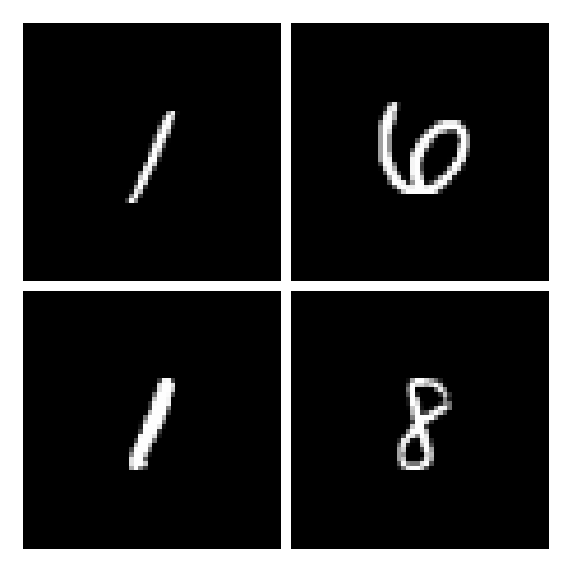

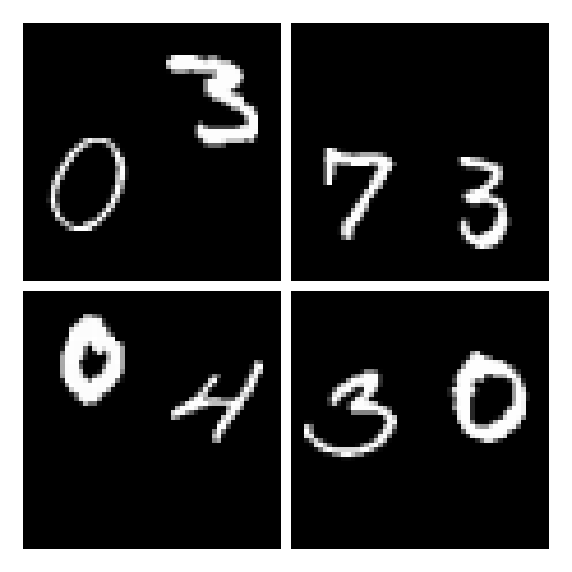

In [8]:
plot_dataset_samples_imgs(zs_mmnist_train, figsize=(9,5))
plot_dataset_samples_imgs(zs_mmnist_test, figsize=(9,5))

### Models

In [9]:
X_DIM = 2  # 2D spatial input 

In [10]:
from functools import partial
from neuralproc import RegularGridsConvolutionalProcess, AttentiveNeuralProcess, NeuralProcessLoss, ConvolutionalProcess
from neuralproc.predefined import UnetCNN, CNN, SelfAttention, MLP, ResConvBlock
from neuralproc import merge_flat_input

In [15]:
from train_imgs import get_model

# models that take into account the grid
models_grided_64 = {}
models_grided_64["GridedCCP"] = get_model("GridedCCP", img_shape=(64,64), n_blocks=4)
models_grided_64["GridedCCP_large"] = get_model("GridedCCP", 
                                                n_blocks=6, kernel_size=11, init_kernel_size=11, img_shape=(64,64))

In [16]:
def add_y_dim(models, datasets):
    """Add y _dim to all ofthe models depending on the dataset."""
    return {data_name: {model_name: partial(model, y_dim=data_train.shape[0]) 
                        for model_name, model in models.items()} 
            for data_name, data_train in datasets.items()}

### Loading Pretrained

In [17]:
def merge_dicts(dicts):
    out = dict()
    for d in dicts:
        out.update(d)
    return out

In [18]:
from neuralproc import NeuralProcessLoss
from utils.train import train_models
from utils.data import cntxt_trgt_collate
import skorch

import os
import contextlib

kwargs = dict(chckpnt_dirname="results/iclr/", 
             is_retrain=False, 
             train_split=skorch.dataset.CVSplit(0.1), # use 10% of data for validation 
             patience=10,
             batch_size=16,
             seed=123,
             runs=6)

# Takes 1-3 mins
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f): # don't print

    trainers_grided_64 = train_models(train_datasets_64, 
                                     add_y_dim(models_grided_64, train_datasets_64),
                                      NeuralProcessLoss,
                                      iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                               is_return_masks=True), 
                                     iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                               is_return_masks=True),
                                     **kwargs) 

In [19]:
models_grided_big = {}
models_grided_big["GridedCCP_large"] = get_model("GridedCCP", n_blocks=6, kernel_size=11, 
                                                 init_kernel_size=11, img_shape=(32, 32))

In [21]:
trainers_grided_big = train_models(train_datasets_64, 
                                     add_y_dim(models_grided_big, train_datasets_64),
                                      NeuralProcessLoss,
                                      iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                               is_return_masks=True), 
                                     iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                               is_return_masks=True),
                                     chckpnt_dirname="results/iclr/", 
             is_retrain=False, 
             train_split=skorch.dataset.CVSplit(0.1), # use 10% of data for validation 
             patience=10,
             batch_size=16,
             seed=123) 


--- Loading zs-multi-mnist/GridedCCP_large/run_0 ---

zs-multi-mnist/GridedCCP_large/run_0 | best epoch: 8 | train loss: -1.32 | valid loss: -1.3319 | test log likelihood: None


# Core Paper

## Qualitative

In [22]:
from neuralproc.utils.predict import AutoregressivePredictor, VanillaPredictor
from utils.helpers import set_seed
from utils.visualize import plot_posterior_img, plot_qualitative_with_kde
from utils.visualize.visualize_imgs import DFLT_FIGSIZE, points_to_grid

### Comparing GridedCCP and GridedCCPXL

In [28]:
from utils.visualize import plot_posterior_img, plot_qualitative_with_kde

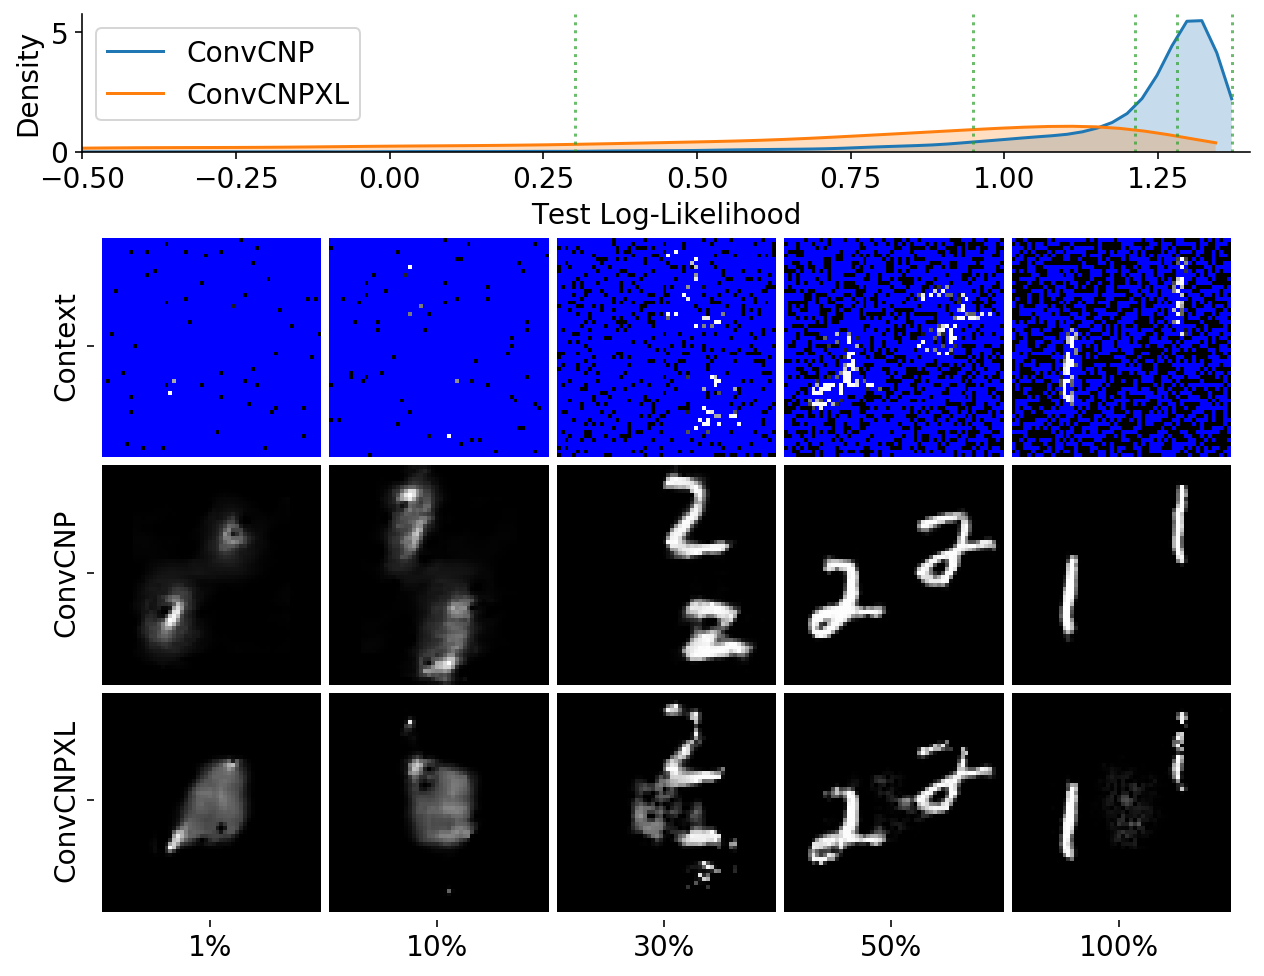

In [24]:
data_name = "zs-multi-mnist"
test_data = zs_mmnist_test

test_loglike = plot_qualitative_with_kde(["ConvCNP", trainers_grided_64['{}/GridedCCP/run_0'.format(data_name)]],
                                         test_data,
                                         named_trainer_compare=["ConvCNPXL", trainers_grided_64['{}/GridedCCP_large/run_0'.format(data_name)]],
                                         figsize=(9, 7),
                                         percentiles=[1,10,30,50,100],
                                        height_ratios=[1,5],
                                         x_lim={"left":-0.5, "right":1.4},
                                         h_pad=0)

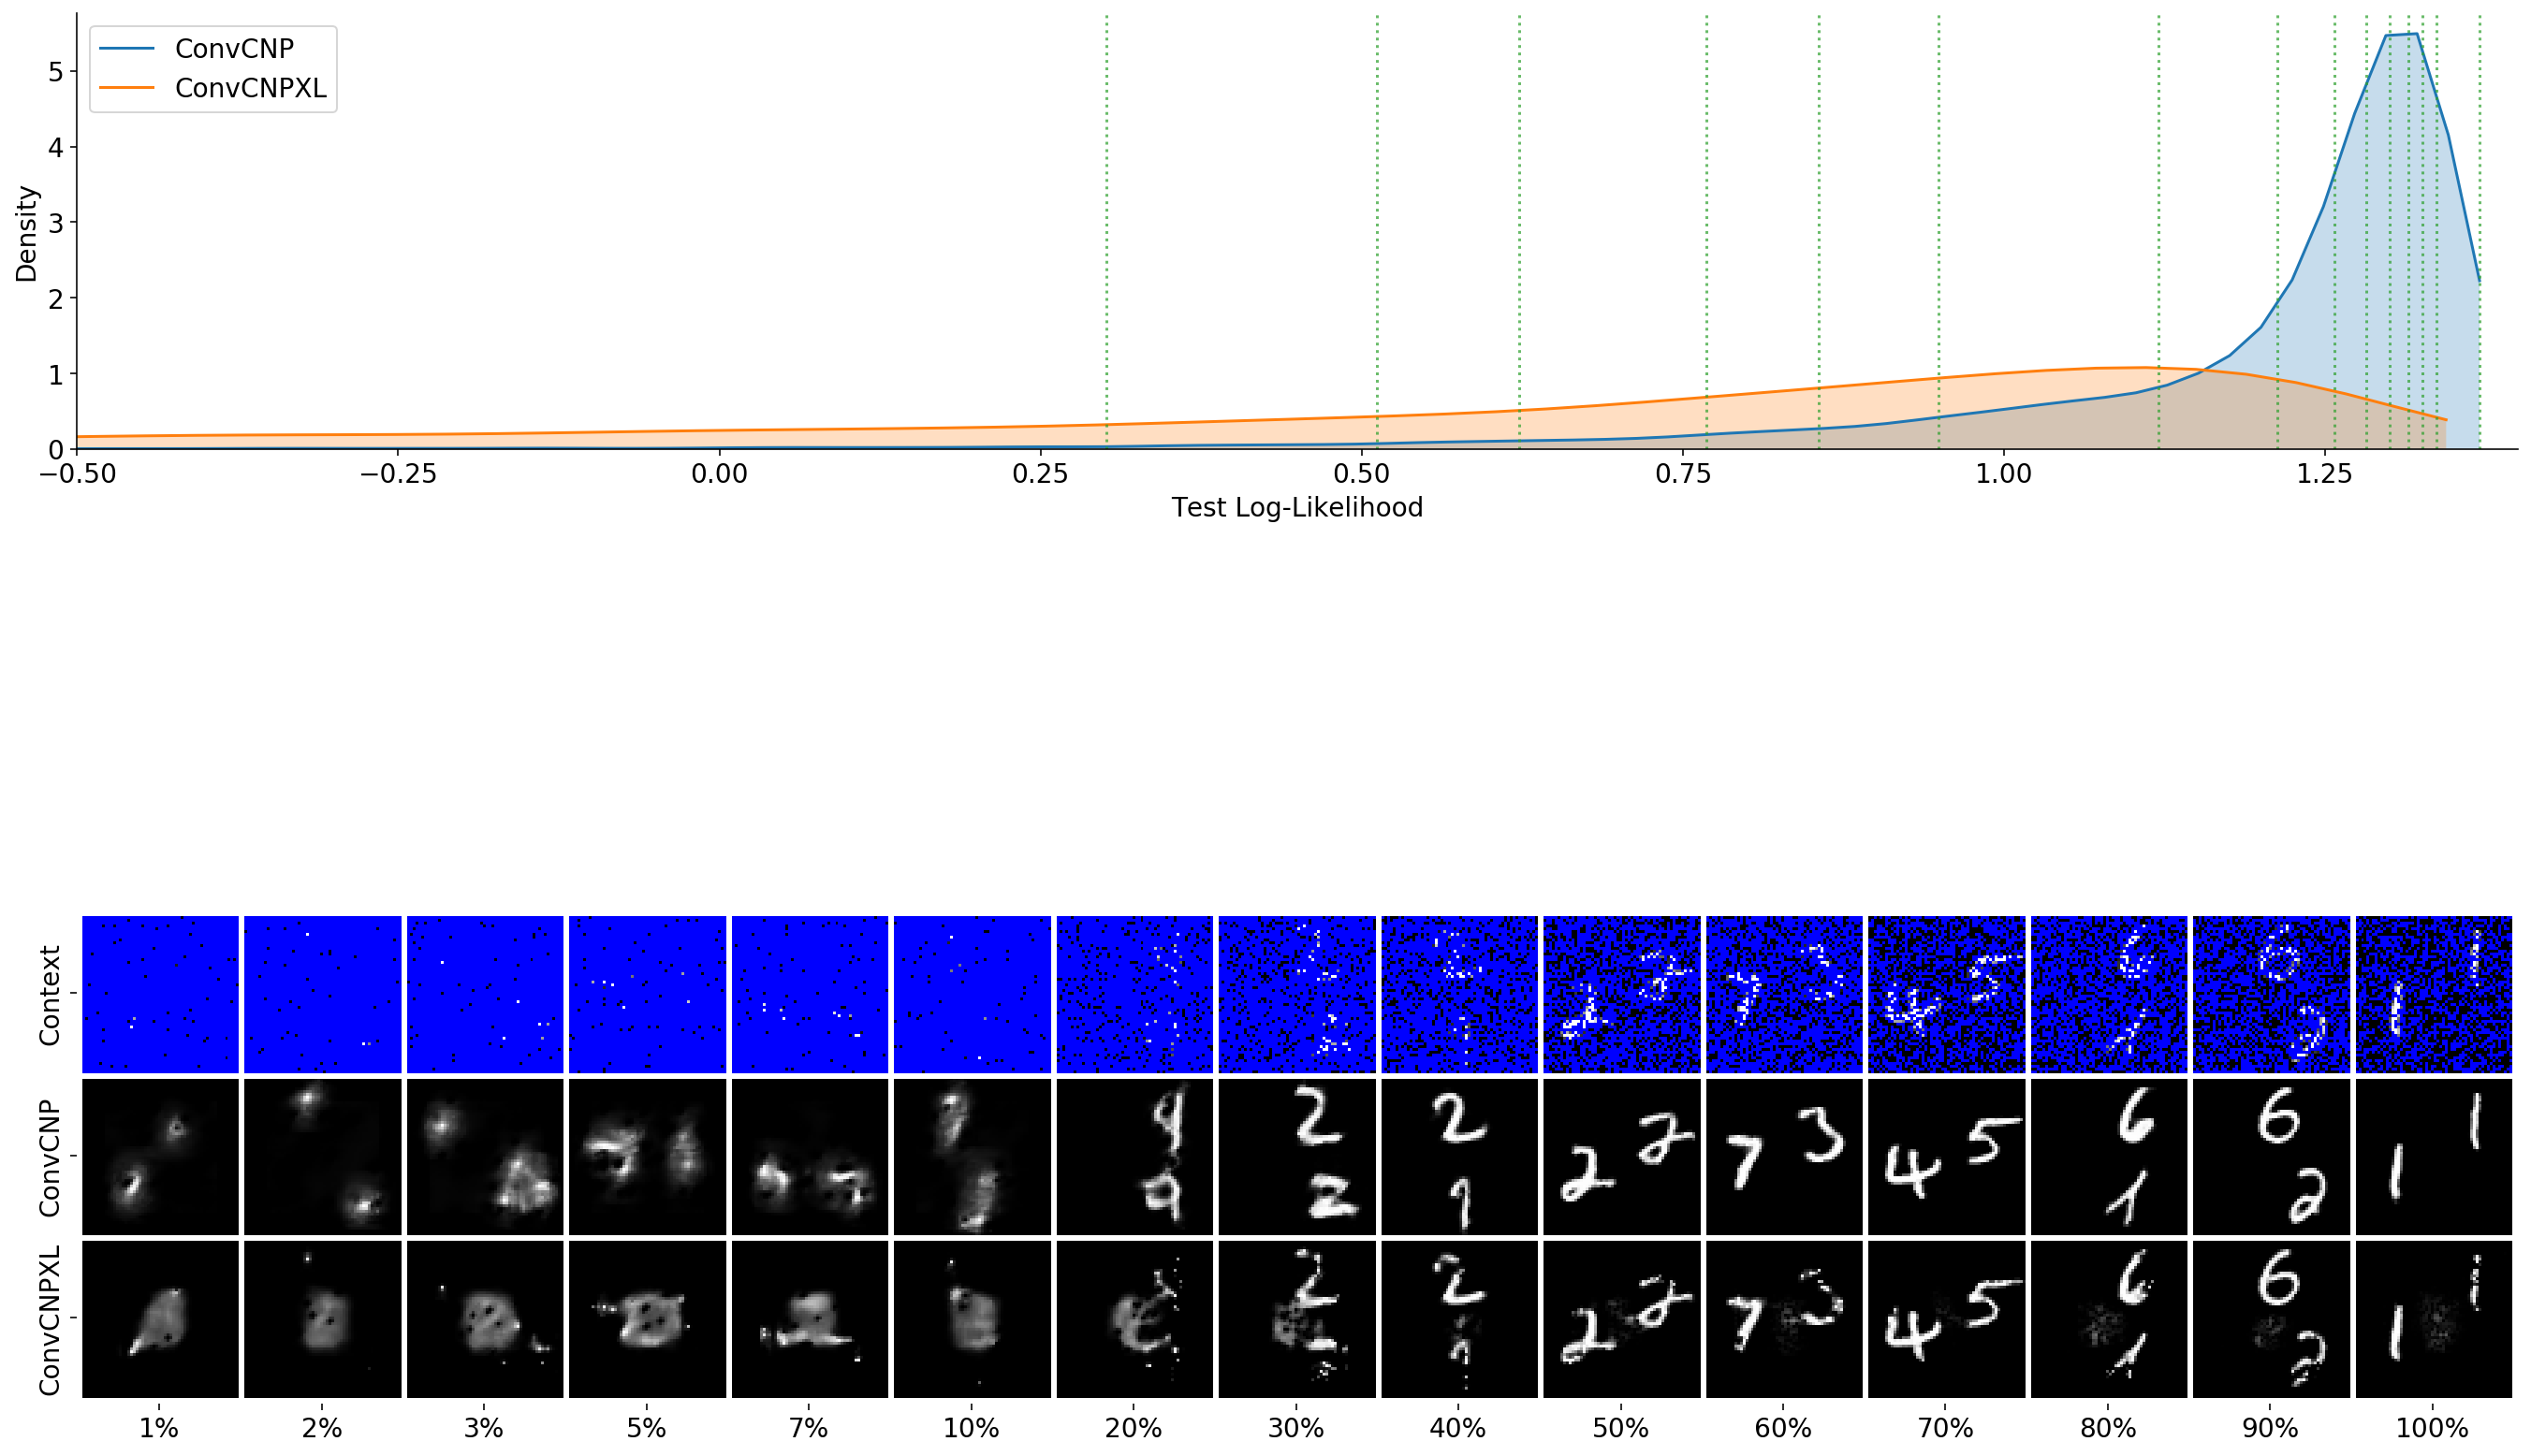

In [26]:
data_name = "zs-multi-mnist"
test_data = zs_mmnist_test

test_loglike = plot_qualitative_with_kde(["ConvCNP", trainers_grided_64['{}/GridedCCP/run_0'.format(data_name)]],
                                         test_data,
                                         named_trainer_compare=["ConvCNPXL", trainers_grided_64['{}/GridedCCP_large/run_0'.format(data_name)]],
                                         figsize=(19, 17),
                                         percentiles=[1,2,3,5,7,10,20,30,40,50,60,70,80,90,100],
                                        height_ratios=[1,5],
                                         x_lim={"left":-0.5, "right":1.4},
                                         h_pad=0)

### The Need for Translation Equivariance

TO-DO: 
- Test the Grided CCP on real image

# Appendix

In [213]:
trainers_grided = merge_dicts([trainers_grided_64, trainers_grided_32, trainers_general, trainers_grided_big])

## Qualitative Results under Different Settings

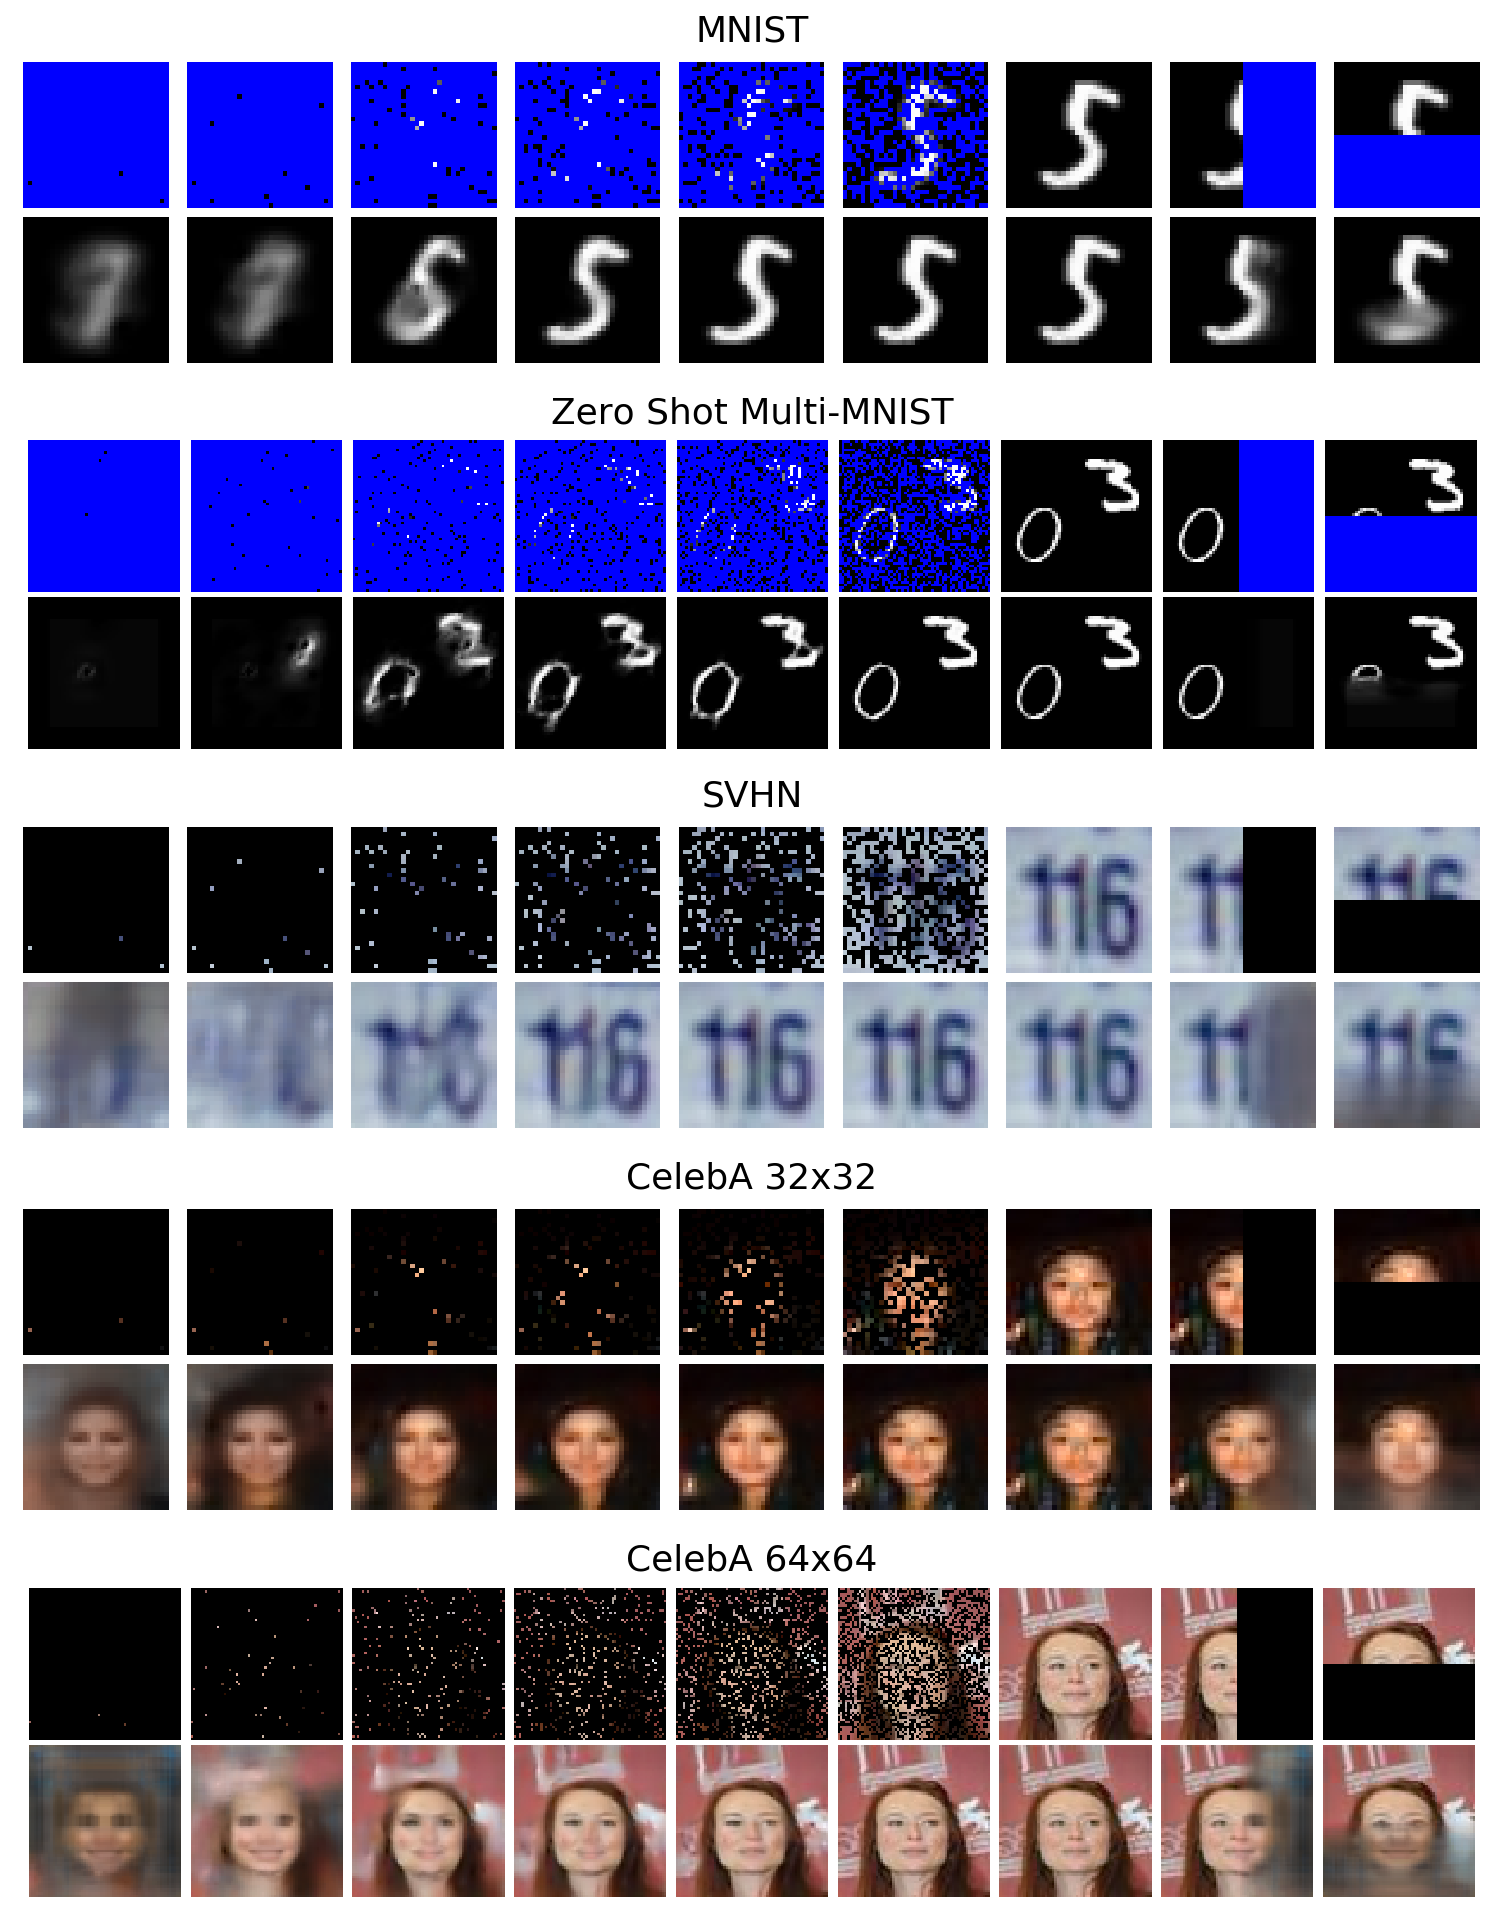

In [129]:
# 3 pixel, 1%, 5%, 10%, 20%, 30%, 50%, 100%, Half Bottom, Half Right
# Rows "mnist", "celeba32", "celeba64", "zs-multi-mnist", "svhn"
# use small model for "zs-multi-mnist"

context_maskers = [RandomMasker(min_nnz=3, max_nnz=3),
                   RandomMasker(min_nnz=0.01, max_nnz=0.01),
                   RandomMasker(min_nnz=0.05, max_nnz=0.05),
                   RandomMasker(min_nnz=0.1, max_nnz=0.1),
                   RandomMasker(min_nnz=0.2, max_nnz=0.2),
                   RandomMasker(min_nnz=0.5, max_nnz=0.5),
                   no_masker, # 100%
                   partial(half_masker, dim=1),
                   partial(half_masker, dim=0),
                  ]

data_models = [(mnist_test, "mnist/GridedCCP_large"),
               (zs_mmnist_test, "zs-multi-mnist/GridedCCP"), # use the translation equivariant one
               (svhn_test, "svhn/GridedCCP_large"),
               (celeba32_test, "celeba32/GridedCCP_large"),
               (celeba64_test, "celeba64/GridedCCP_large")
              ]

fig, axes = plt.subplots(len(data_models), 1, figsize=(31,17))

for i,(data_test, model) in enumerate(data_models):
    grid = torch.cat([plot_posterior_img(data_test, 
                                      GridCntxtTrgtGetter(context_masker=c,
                                                         target_masker=no_masker), 
                                      trainers_grided['{}/run_0'.format(model)].module_.cpu(), 
                                      MeanPredictor=VanillaPredictor,
                                      n_plots=1,
                                      is_uniform_grid=True,
                                      is_return=True,
                                      seed=123 +  int("celeba64" in model)) # don't  show same images for celeba32 and celeba64
        for c in context_maskers], dim=2)
    
    axes[i].imshow(grid.permute(1, 2, 0).numpy())
    axes[i].axis("off")
    axes[i].set_title(data_names[model.split("/")[0]], fontsize=18)

## Understanding the first Layer

First Layer of small GridedCCP


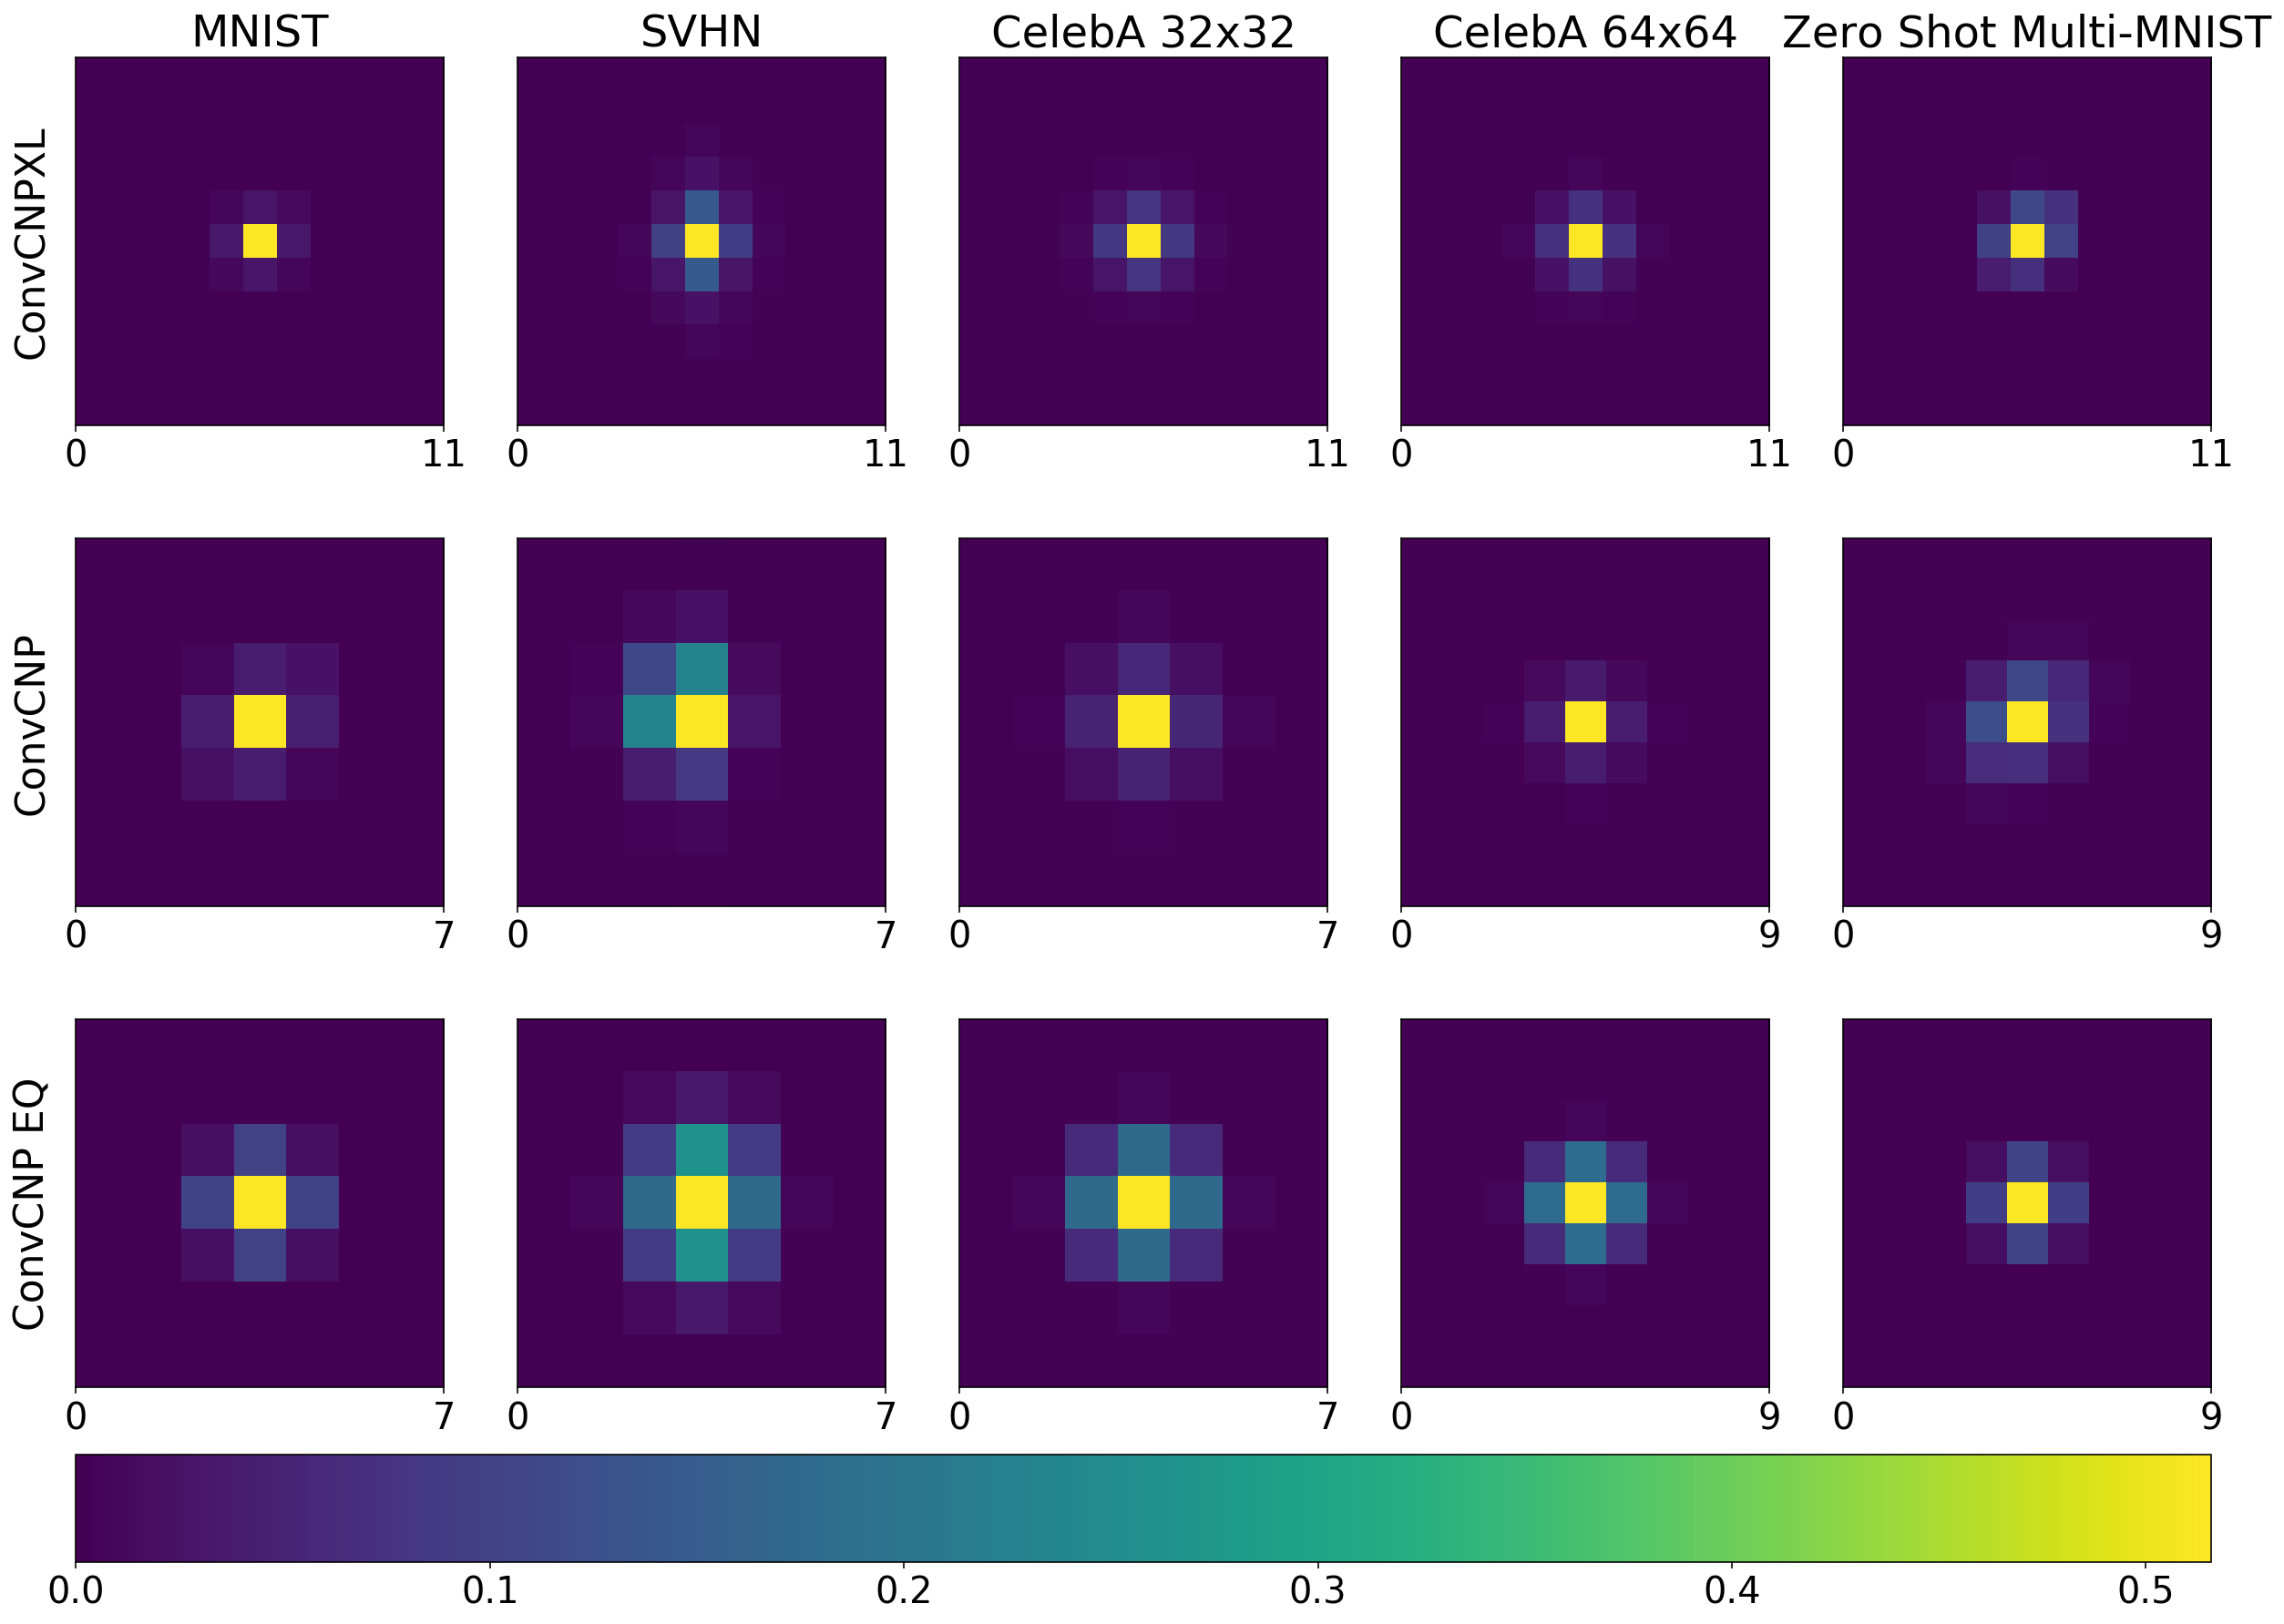

In [274]:


dataset = ["mnist", "svhn", "celeba32", "celeba64", "zs-multi-mnist"]
fig, axes = plt.subplots(3,len(dataset), figsize=(21,17))

plt.rcParams.update({"font.size": 20})

for i, d in enumerate(dataset):
    for j, name in enumerate(["GridedCCP_large", "GridedCCP", "GridedCCP_rbf"]):
        # use abs because I force positive weights in my implementation
        txt = '{}/{}/run_0'
        if name == "GridedCCP_rbf":
            conv=trainers_grided[txt.format(d, name)].module_.conv
            marginal_x = torch.softmax(conv.exponent * conv.weights_x, dim=0)
            marginal_y = torch.softmax(conv.exponent * conv.weights_y, dim=0).T
            weights_layer_1 = marginal_x @ marginal_y
        else:
            try:
                weights_layer_1 = trainers_grided[txt.format(d, name)].module_.conv.weight.squeeze(1)[0].abs()
            except:
                weights_layer_1 = trainers_grided[txt.format(d, name)].module_.conv.weight.squeeze(1)[0].abs()
        im = axes[j, i].imshow(weights_layer_1.detach().numpy())
        if j == 0:
            axes[j, i].set_title(data_names[d])
        axes[j, i].set_xticks([-0.5, weights_layer_1.shape[0]-0.5])
        axes[j, i].set_xticklabels([0, weights_layer_1.shape[0]])
        axes[j, i].set_yticks([])
    
colorbar=fig.colorbar(im,  orientation="horizontal", ax=axes.ravel().tolist(), pad=0.04)

for ax, row in zip(axes[:,0], ["ConvCNPXL", "ConvCNP", "ConvCNP EQ"]):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation="vertical", 
                fontsize=22)
    
print("First Layer of small GridedCCP")

We see that it when it is not translation equivariant it uses a non RBF like first layer.

## Loosing Translation Equivariance with Large Receptive Field

When using a large receptuve field in our datasets, the mdoel is able to learn to not be translation equivariant.

In [41]:
context_maskers = [RandomMasker(min_nnz=3, max_nnz=3),
                   RandomMasker(min_nnz=0.01, max_nnz=0.01),
                   RandomMasker(min_nnz=0.05, max_nnz=0.05),
                   RandomMasker(min_nnz=0.1, max_nnz=0.1),
                   RandomMasker(min_nnz=0.2, max_nnz=0.2),
                   RandomMasker(min_nnz=0.5, max_nnz=0.5),
                   no_masker, # 100%
                   partial(half_masker, dim=1),
                   partial(half_masker, dim=0),
                  ]

data_models = [(mnist_test, "mnist/GridedCCP"),
               (zs_mmnist_test, "zs-multi-mnist/GridedCCP"), # use the translation equivariant one
               (svhn_test, "svhn/GridedCCP"),
               (celeba32_test, "celeba32/GridedCCP"),
               (celeba64_test, "celeba64/GridedCCP")
              ]



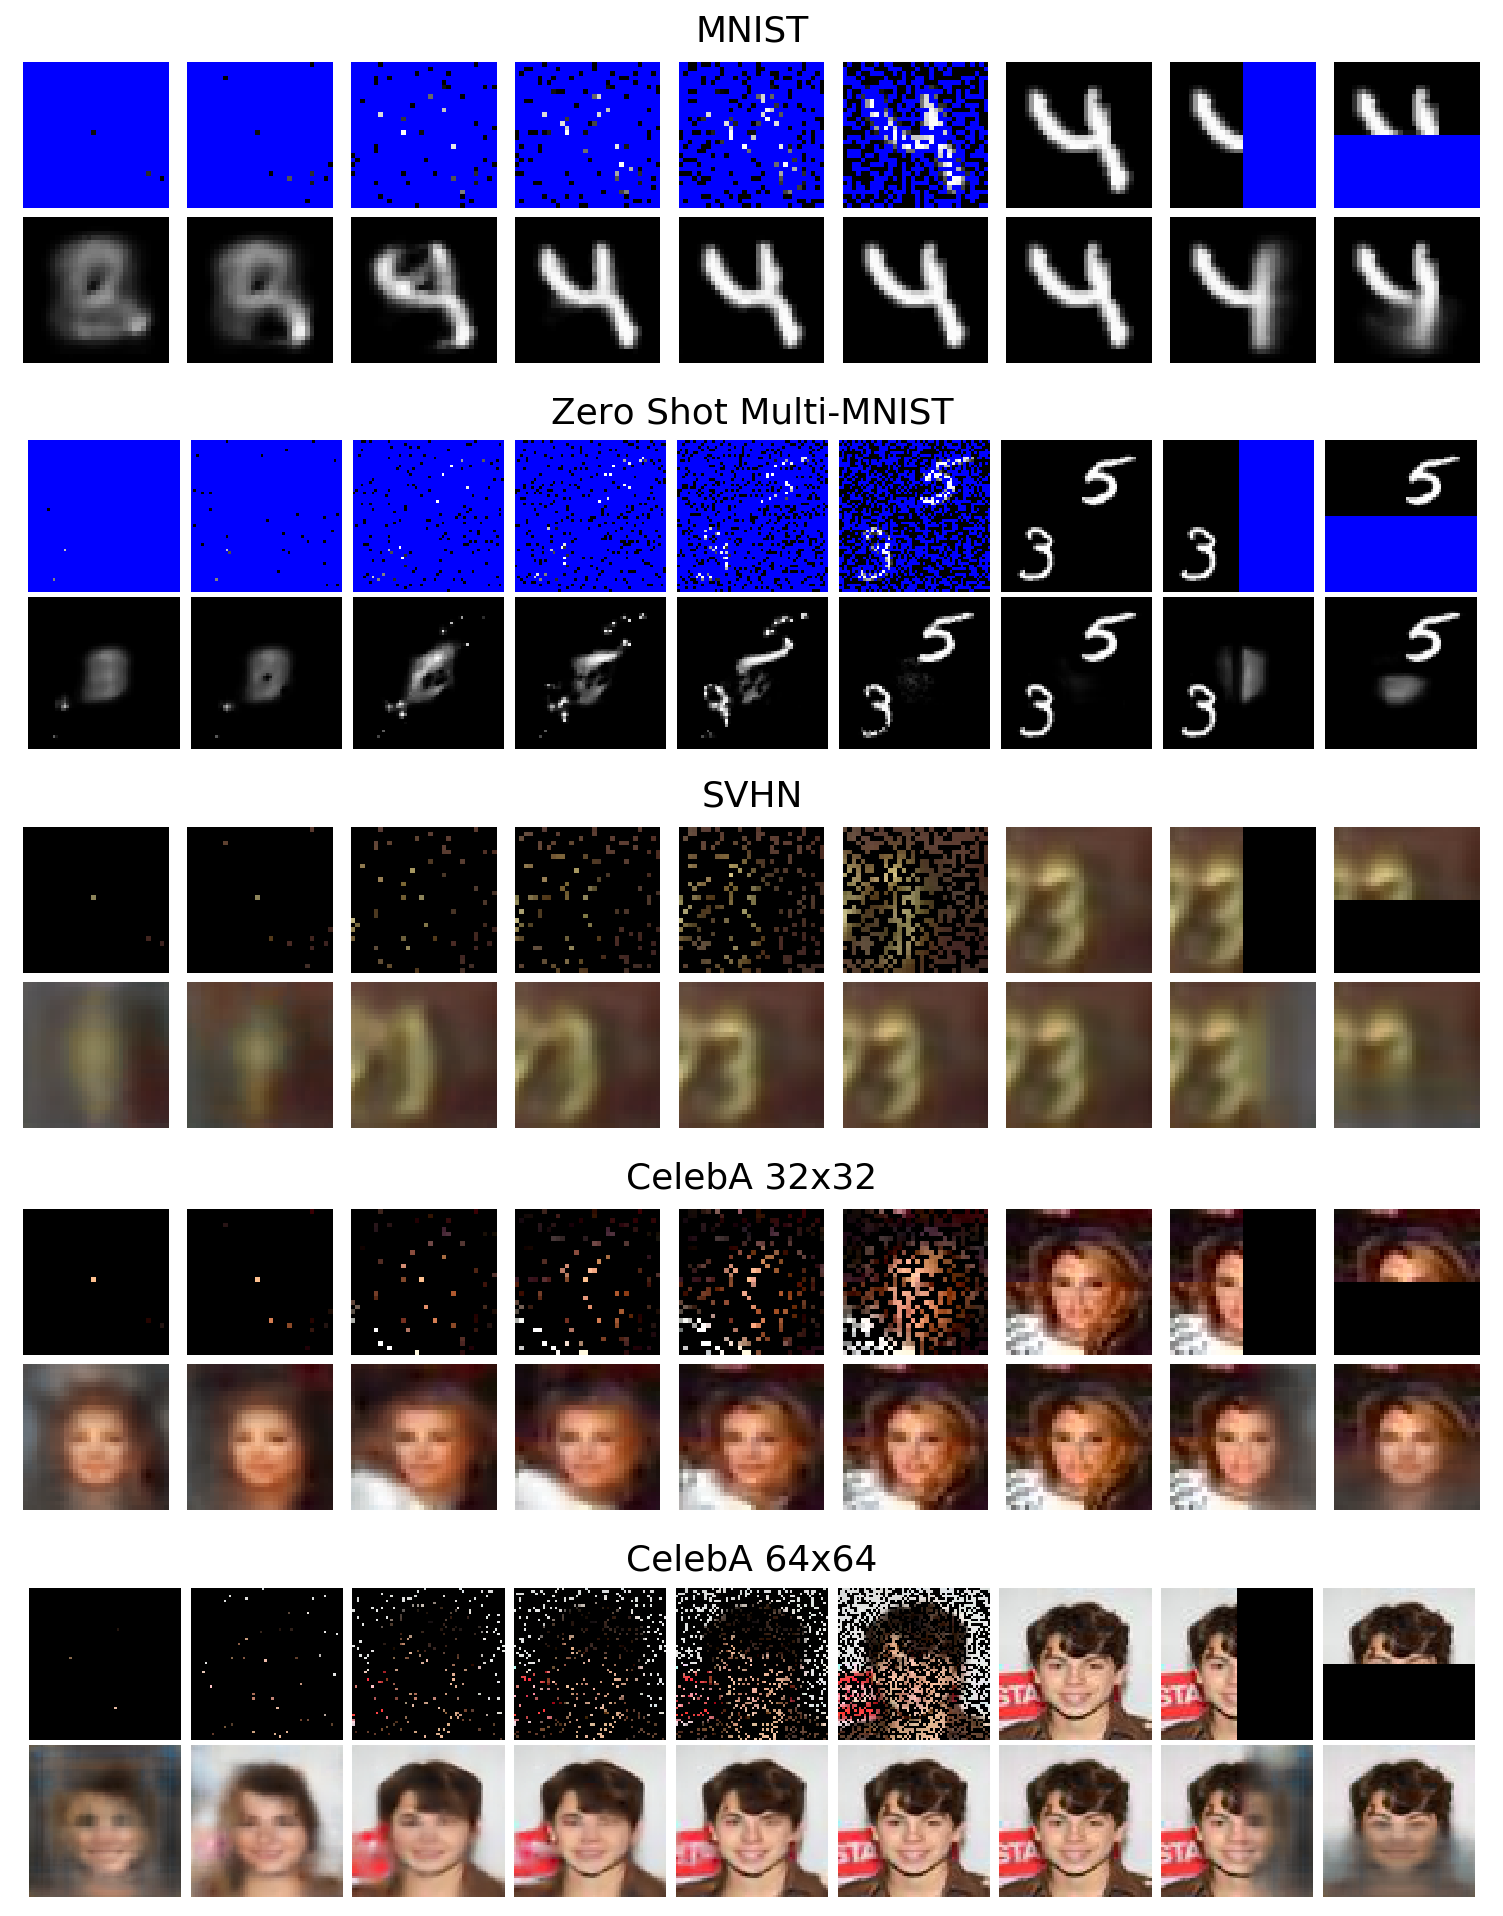

In [42]:
# Large Model

fig, axes = plt.subplots(len(data_models), 1, figsize=(31,17))

for i,(data_test, model) in enumerate(data_models):
    grid = torch.cat([plot_posterior_img(data_test, 
                                      GridCntxtTrgtGetter(context_masker=c,
                                                         target_masker=no_masker), 
                                      trainers_grided['{}_large/run_0'.format(model)].module_.cpu(), 
                                      MeanPredictor=VanillaPredictor,
                                      n_plots=1,
                                      is_uniform_grid=True,
                                      is_return=True,
                                      seed=1 +  int("celeba64" in model)) # don't  show same images for celeba32 and celeba64
        for c in context_maskers], dim=2)
    
    axes[i].imshow(grid.permute(1, 2, 0).numpy())
    axes[i].axis("off")
    axes[i].set_title(data_names[model.split("/")[0]], fontsize=18)




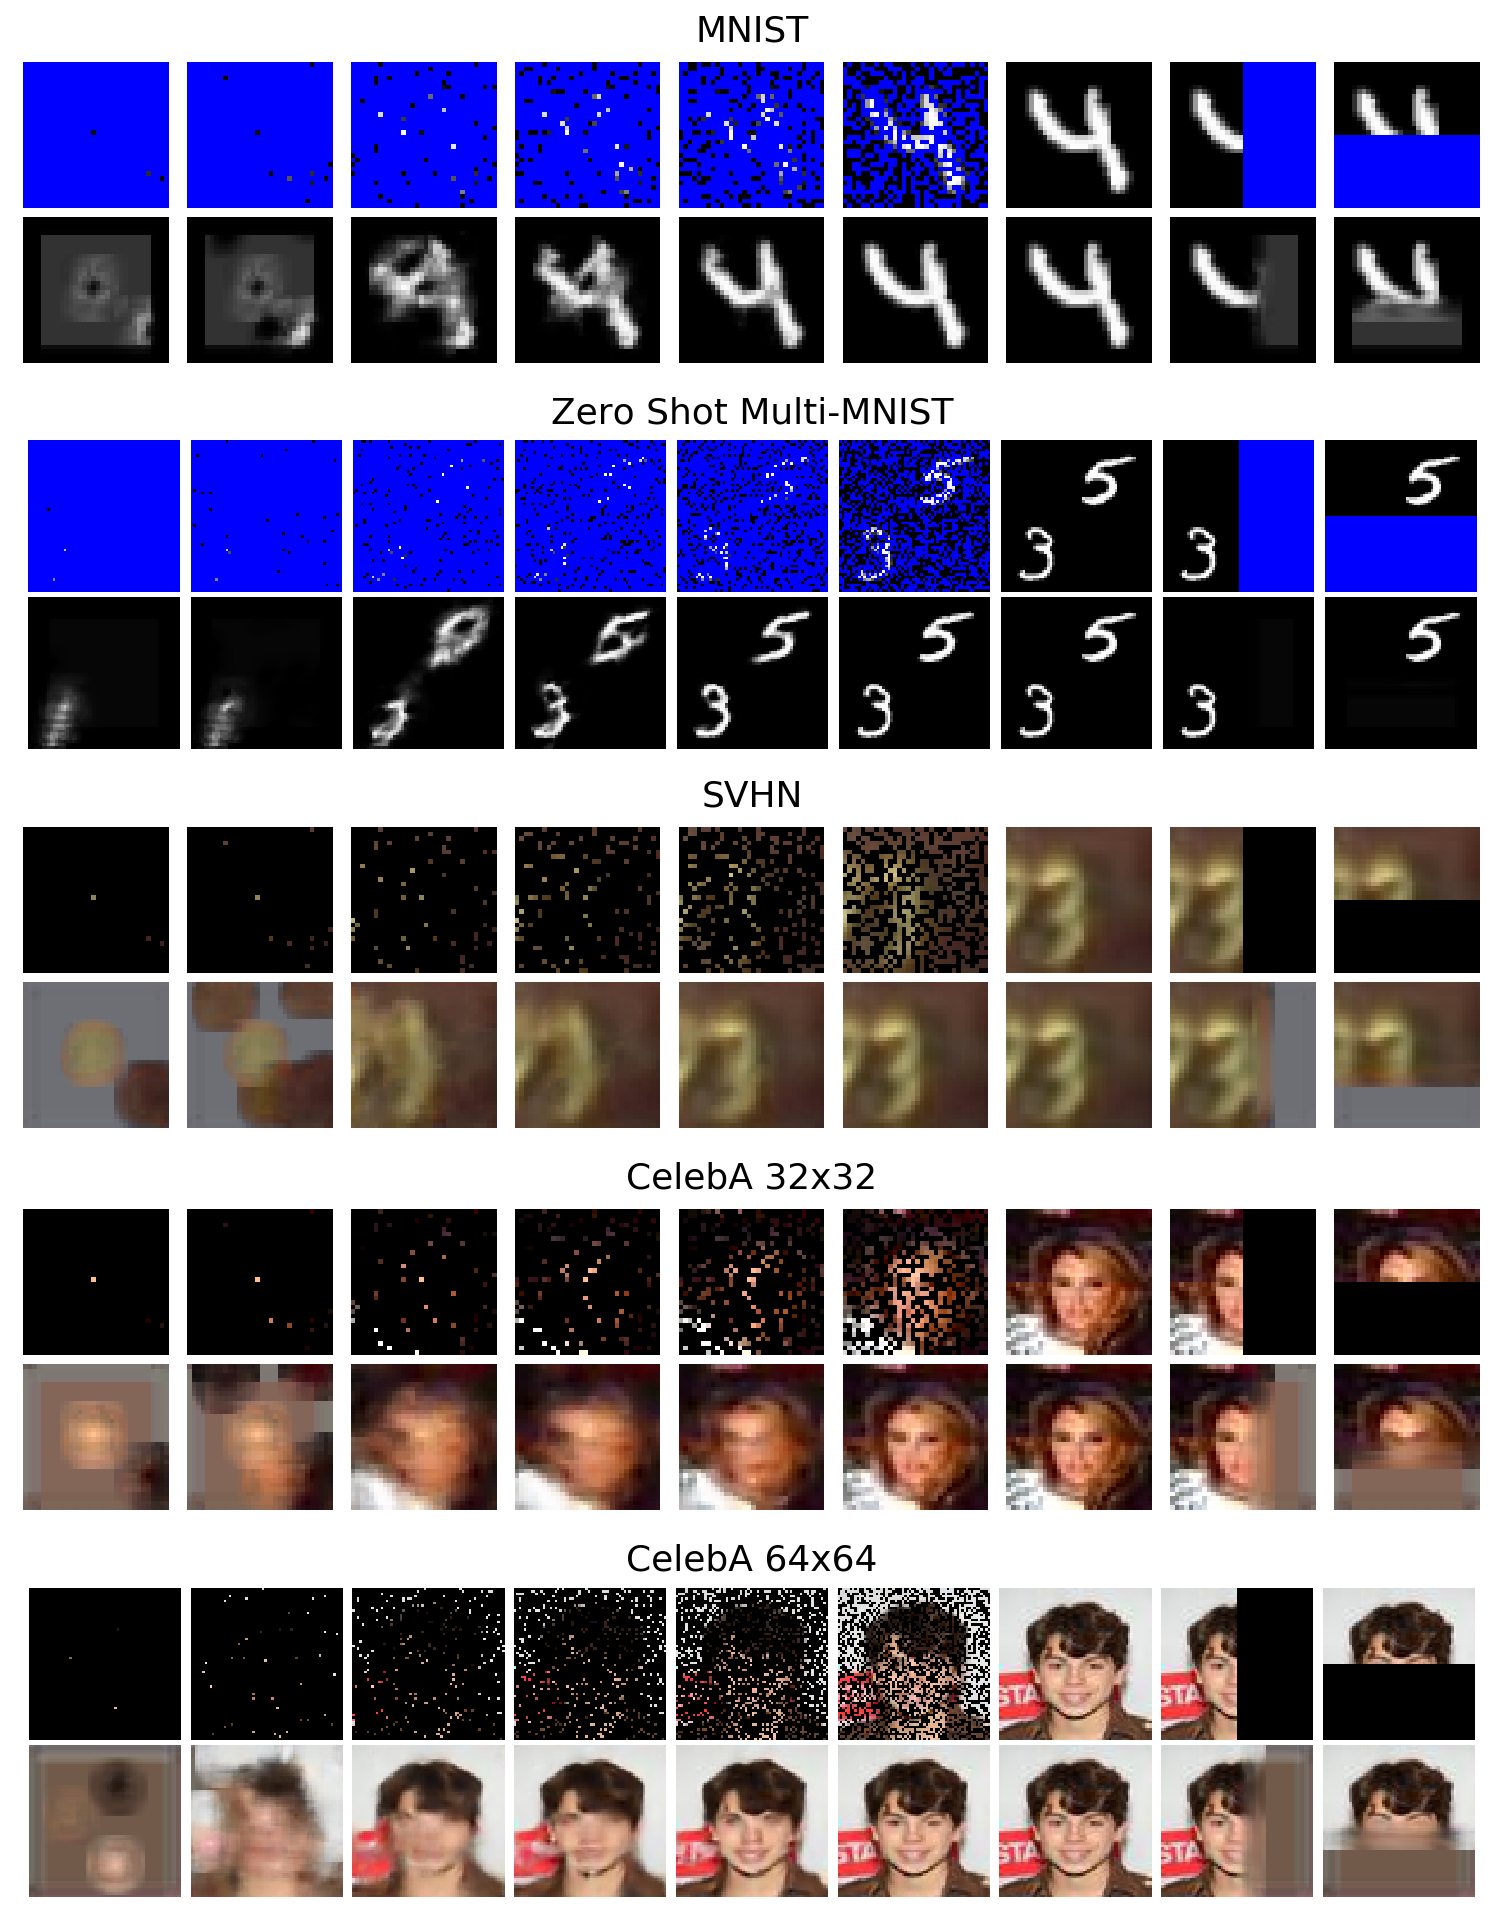

In [43]:
# Small Model

fig, axes = plt.subplots(len(data_models), 1, figsize=(31,17))

for i,(data_test, model) in enumerate(data_models):
    grid = torch.cat([plot_posterior_img(data_test, 
                                      GridCntxtTrgtGetter(context_masker=c,
                                                         target_masker=no_masker), 
                                      trainers_grided['{}/run_0'.format(model)].module_.cpu(), 
                                      MeanPredictor=VanillaPredictor,
                                      n_plots=1,
                                      is_uniform_grid=True,
                                      is_return=True,
                                      seed=1 +  int("celeba64" in model)) # don't  show same images for celeba32 and celeba64
        for c in context_maskers], dim=2)
    
    axes[i].imshow(grid.permute(1, 2, 0).numpy())
    axes[i].axis("off")
    axes[i].set_title(data_names[model.split("/")[0]], fontsize=18)

We see that it loses translation equivariance

## Will Not Mention But Interesting
- Autoregressive is hard to make work for colored images because it gets one channel off by a little and then diverges. I.e. variance is too high even if expectation might be good.
- Training with autoregressive helps a little but not much (+ the results are bad when not testing with AR)
- Training with autoregressive where the mask used is a learned function inversely proportional to the predicted variance works best, but still the results are not much better than in the non AR.


Autoregessive examples:

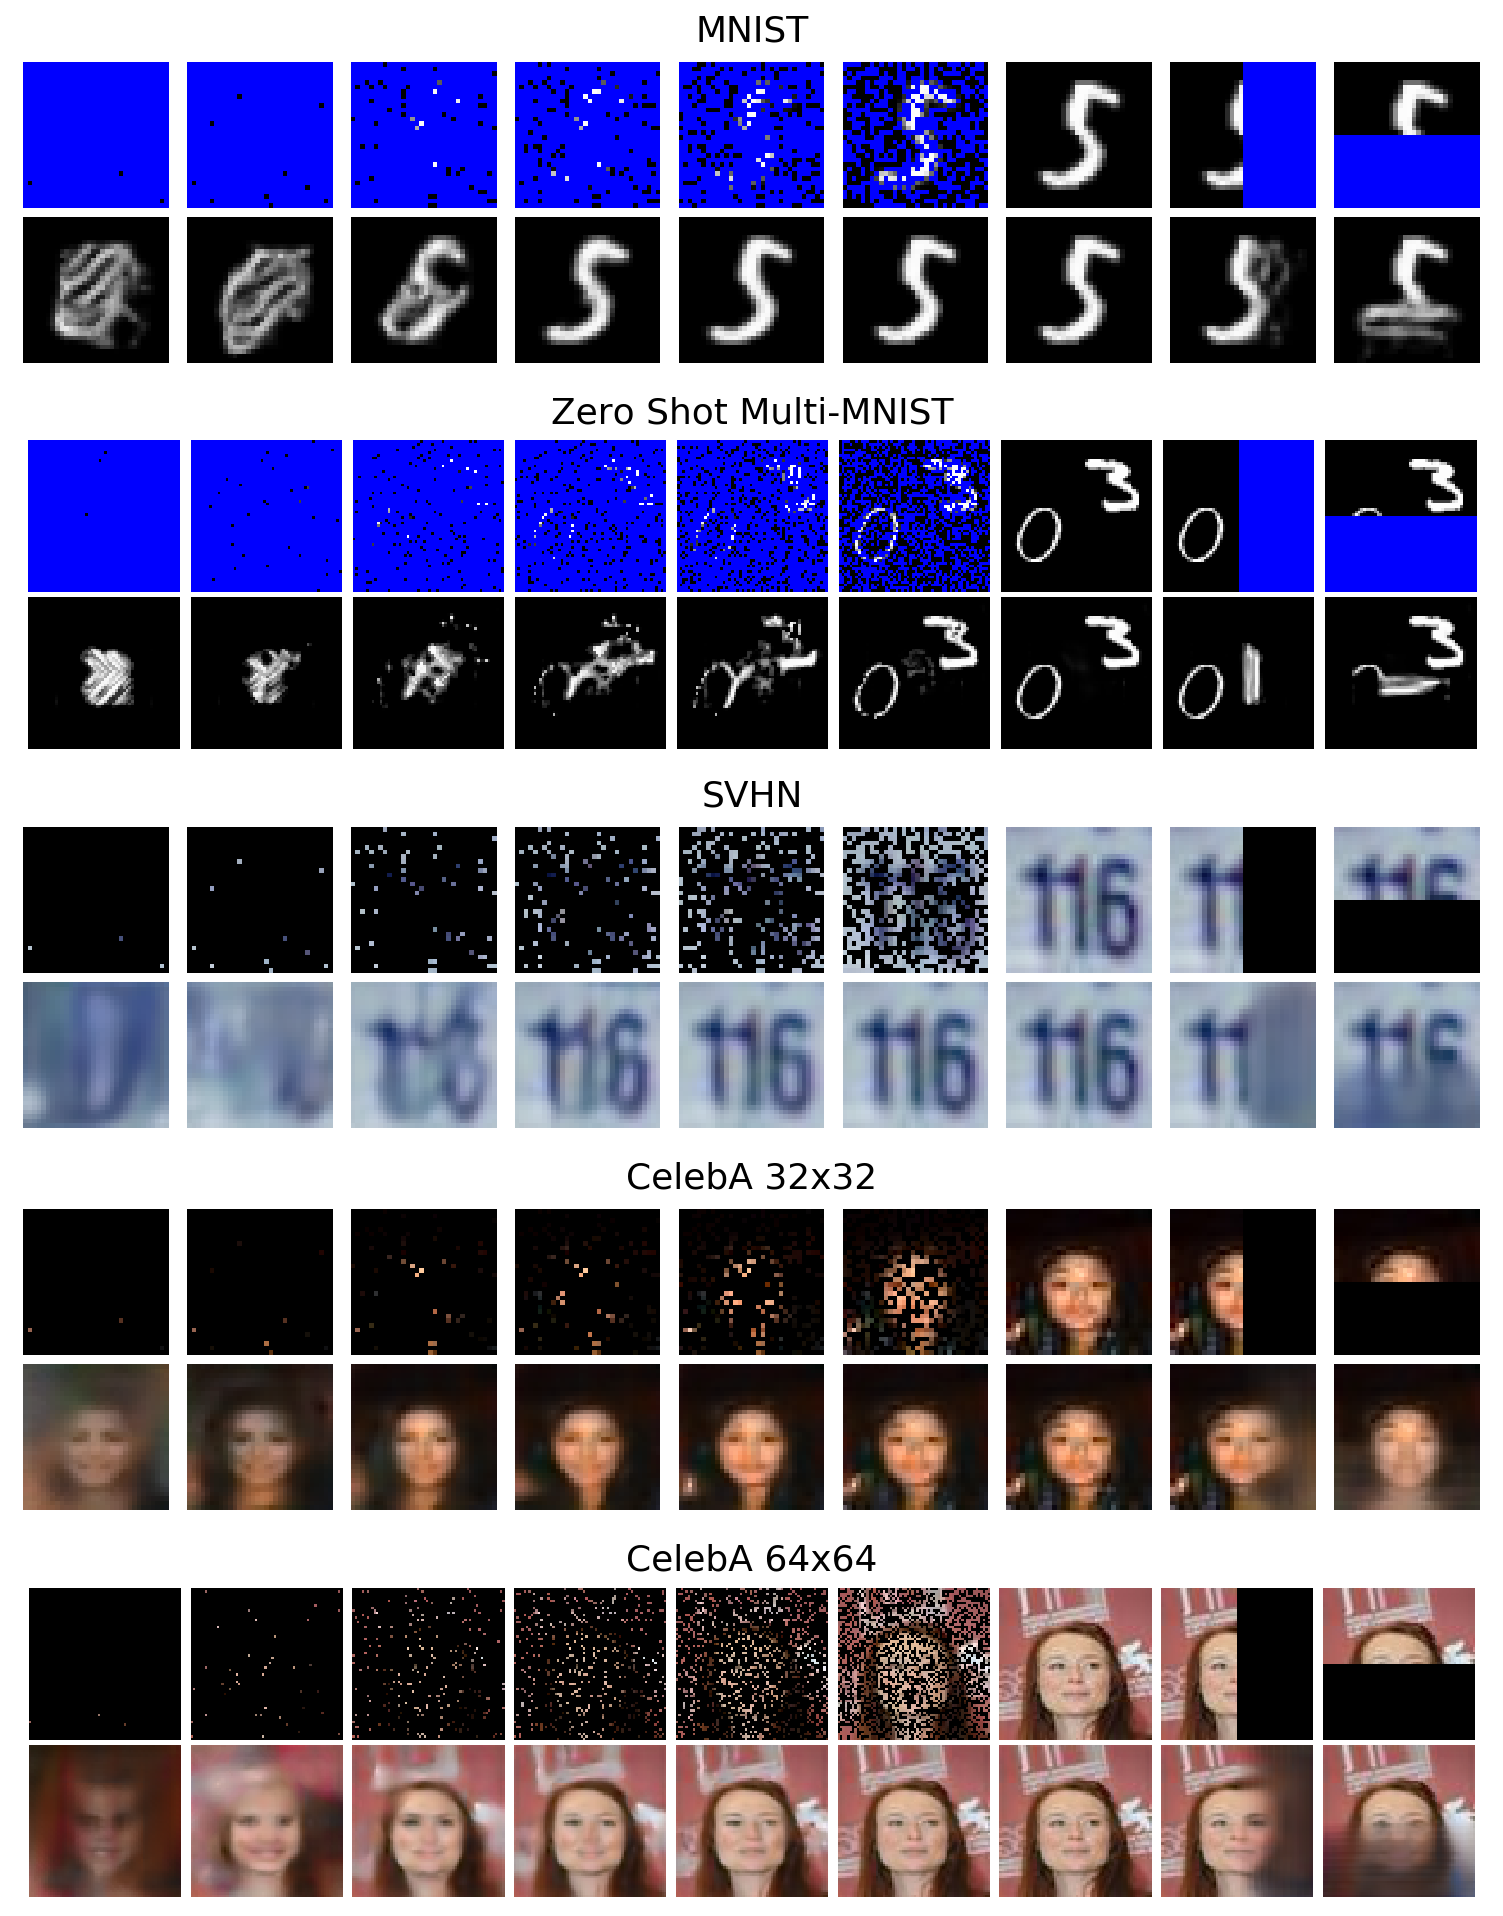

In [44]:
from neuralproc.utils.predict import AutoregressivePredictor, VanillaPredictor, GenNextAutoregressivePixelL1

# Large Model

fig, axes = plt.subplots(len(data_models), 1, figsize=(31,17))

for i,(data_test, model) in enumerate(data_models):
    grid = torch.cat([plot_posterior_img(data_test, 
                                      GridCntxtTrgtGetter(context_masker=c,
                                                         target_masker=no_masker), 
                                      trainers_grided['{}_large/run_0'.format(model)].module_.cpu(), 
                                      MeanPredictor=partial(AutoregressivePredictor,
                                                            gen_autoregressive_trgts=GenNextAutoregressivePixelL1(3)),
                                      n_plots=1,
                                      is_uniform_grid=True,
                                      is_return=True,
                                      seed=123 +  int("celeba64" in model)) # don't  show same images for celeba32 and celeba64
        for c in context_maskers], dim=2)
    
    axes[i].imshow(grid.permute(1, 2, 0).numpy())
    axes[i].axis("off")
    axes[i].set_title(data_names[model.split("/")[0]], fontsize=18)





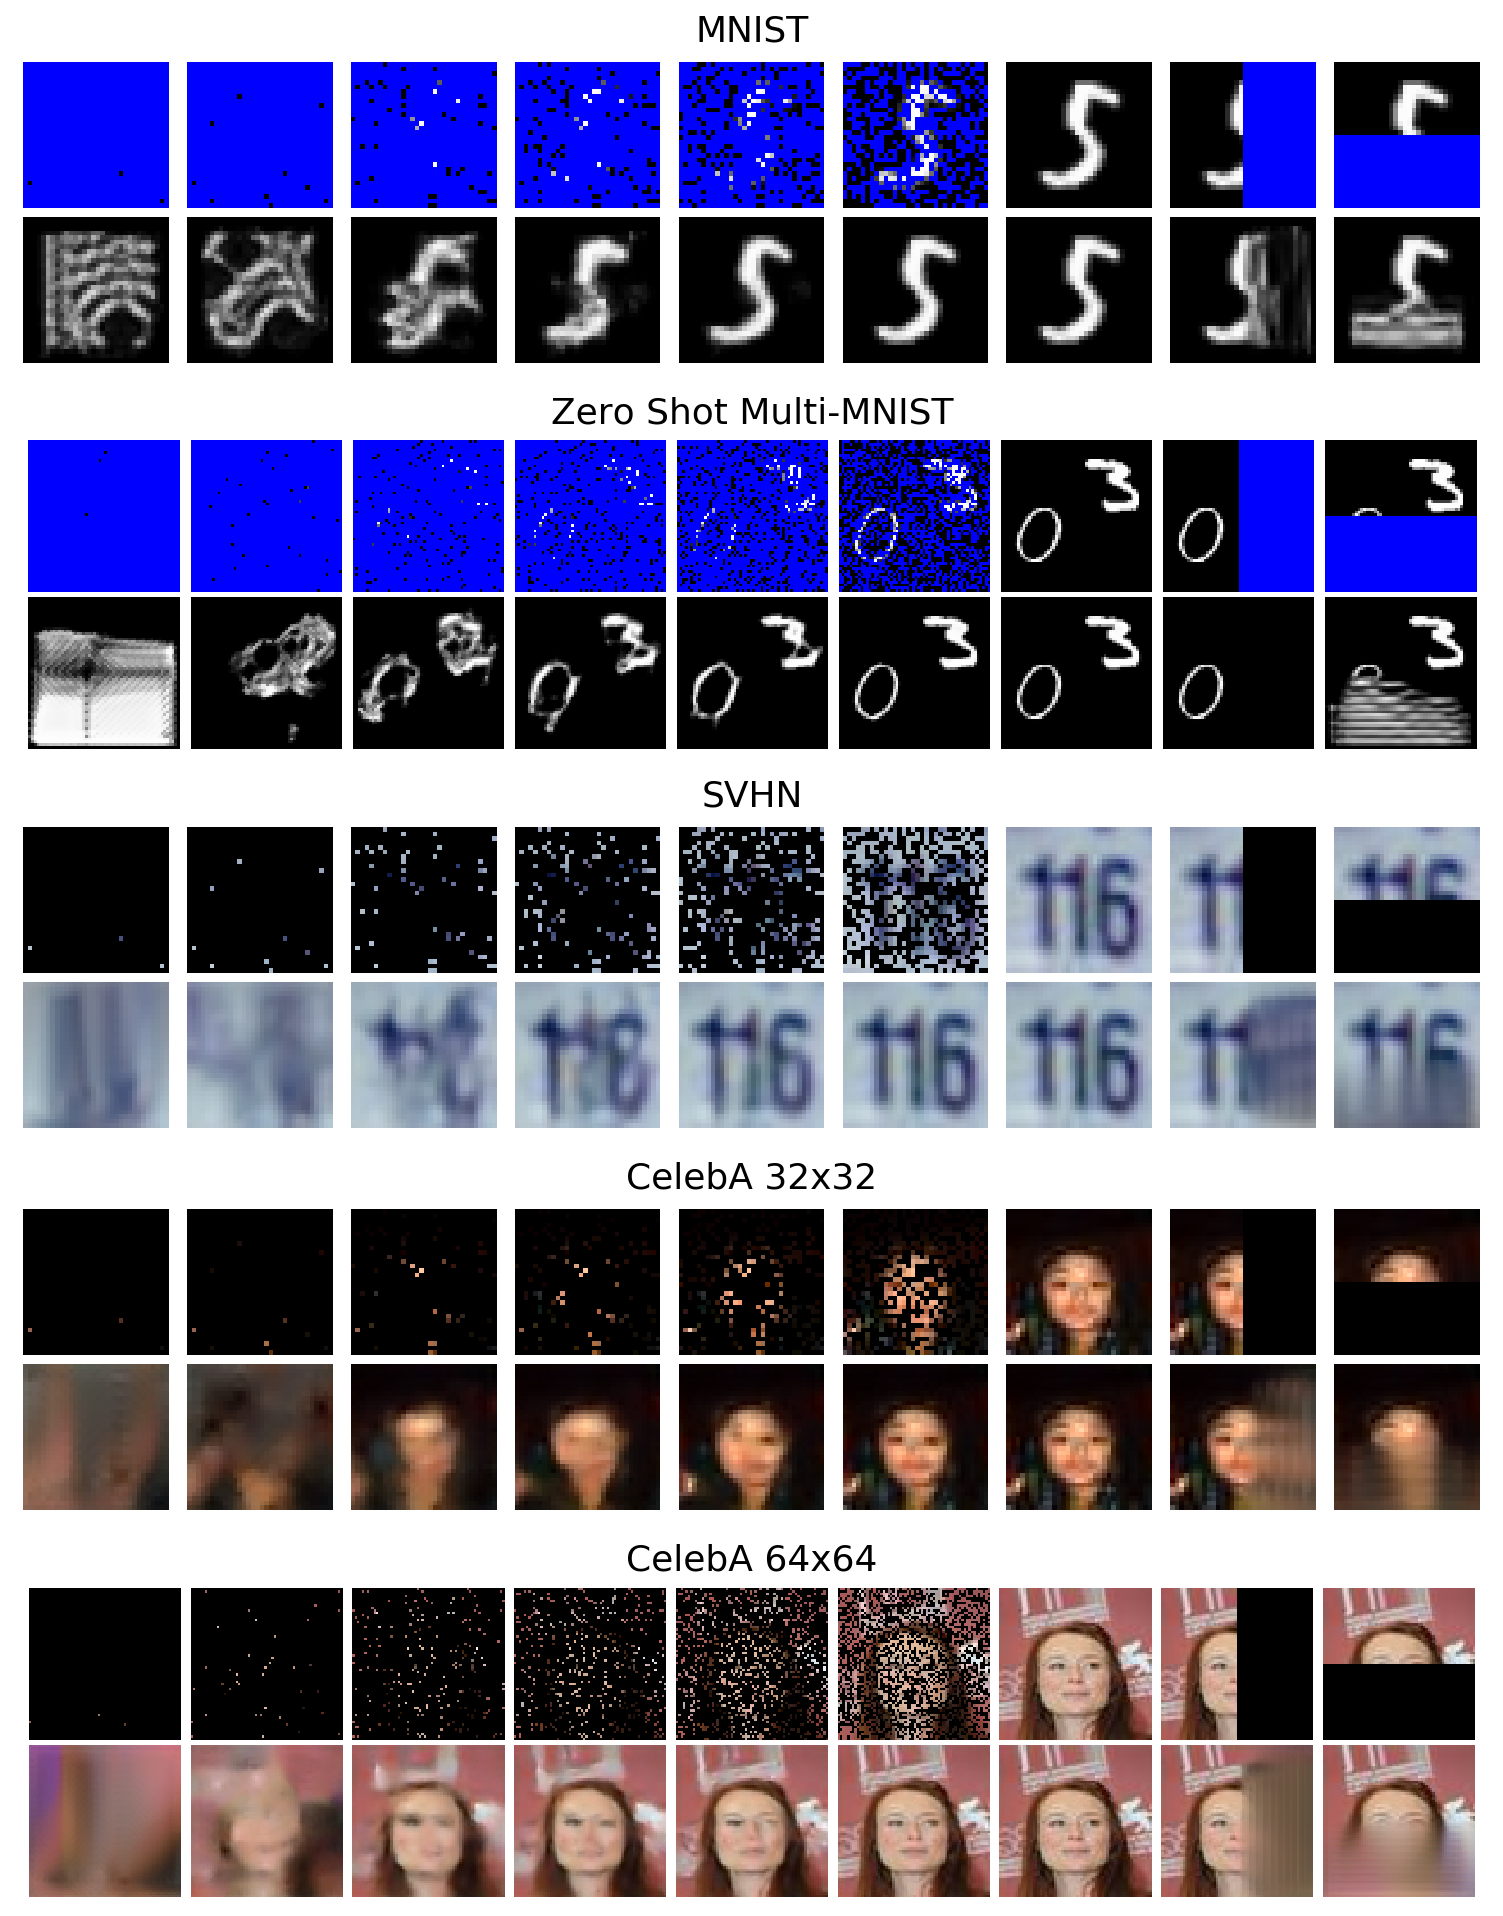

In [45]:
from neuralproc.utils.predict import AutoregressivePredictor, VanillaPredictor, GenNextAutoregressivePixelL1

# Large Model

fig, axes = plt.subplots(len(data_models), 1, figsize=(31,17))

for i,(data_test, model) in enumerate(data_models):
    grid = torch.cat([plot_posterior_img(data_test, 
                                      GridCntxtTrgtGetter(context_masker=c,
                                                         target_masker=no_masker), 
                                      trainers_grided['{}/run_0'.format(model)].module_.cpu(), 
                                      MeanPredictor=partial(AutoregressivePredictor,
                                                            gen_autoregressive_trgts=GenNextAutoregressivePixelL1(3)),
                                      n_plots=1,
                                      is_uniform_grid=True,
                                      is_return=True,
                                      seed=123 +  int("celeba64" in model)) # don't  show same images for celeba32 and celeba64
        for c in context_maskers], dim=2)
    
    axes[i].imshow(grid.permute(1, 2, 0).numpy())
    axes[i].axis("off")
    axes[i].set_title(data_names[model.split("/")[0]], fontsize=18)




